In [1]:
import warnings

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(24)

import seaborn as sns

plt.rcParams["figure.figsize"] = 9, 4.51

import expectexception

import feets

# warnings.simplefilter("ignore", feets.extractors.ExtractorWarning)

# Extractors Tutorial

## Introduction

This tutorial is a guide of how you can create your custom feature extraction routine
and add this extractor to feets.

## Fundamentals

- The feature extraction as modeled as a class.
- The class must inerith from `feets.Extractor`
- The extractor class must has at least three elements
    1. **data**: list with at least one valid feets data 
       (*time*, *magnitude*, *error*, *magnitude2*, *aligned_time*, *aligned_magnitude*, *aligned_magnitude2*, 
       *aligned_error* or *aligned_error2*)
    2. **features**: list with the name of the features that this extractor generates.
    3. **fit**: a method with the same parameters defined in the `data` list. `fit()` must return
       a dictionary with keys equals to the `features` list.

## Example 1: `MaxMagMinTime` extractor

Let's say we need to create a feature extractor called **MaxMagMinTime** that must return 2 features:

1. **magmax**: The maximun magnitude 
2. **mintime**: the minimun time

In [2]:
import feets

class MaxMagMinTime(feets.Extractor):  # must inherit from Extractor

    data = ['magnitude', 'time']  # Which data is needed 
                                  # to calculate this feature
    
    features = ["magmax", "mintime"] # The names of the expected 
                                     # feature
    
    # The values of data are the params
    def fit(self, magnitude, time):        
        # The return value must be a dict with the same values 
        # defined in  features
        return {"magmax": magnitude.max(), "mintime": time.min()}  

Finally to make the extractor available for the `FeaturSpace` class, you need to register it with the command:

In [3]:
feets.register_extractor(MaxMagMinTime)

__main__.MaxMagMinTime

Now the extractor are available as any other provided in feets:

In [4]:
# let's create the feature-space
fs = feets.FeatureSpace(only=["magmax", "mintime"])
fs

<FeatureSpace: MaxMagMinTime()>

In [5]:
# extract the features
fs.extract(time=[1,2,3], magnitude=[100, 200, 300])

FeatureSet(features=<magmax, mintime>, timeserie=<time, magnitude>)

## Example 2: `WeightedMean` extractor - Optional data.

Any extractor can set some parameters of the light curves as optional. For this, the `Extractors` provide the `optional` attribute which is a list that any component defined in `data` can have.

For example, if we wanted to make the `WeightedMean` extractor which calculates the average of the magnitudes optionally weighted by the error:

In [6]:
class WeightedMean(feets.Extractor):

    data = ['magnitude', 'error']
    optional = ['error']
    
    features = ["weighted_mean"] 
    
    # if error is not provided to the FeatureSpace,
    # the value of erro will be None.
    def fit(self, magnitude, error):
        if error is None:
            weighted_mean = np.average(magnitude) 
        else:
            weighted_mean = np.average(magnitude, weights=error)
        return {"weighted_mean": weighted_mean}  

In [7]:
feets.register_extractor(WeightedMean)

__main__.WeightedMean

The interesting thing about this extractor is that it is selected by the `FeatureSpace` regardless of whether we request for the error or not (In both cases the new extractor will be at the end of the set):

In [8]:
fs = feets.FeatureSpace(data=["magnitude", "error"])
fs.features_extractors_

frozenset({Amplitude(),
           AndersonDarling(),
           AutocorLength(nlags=100),
           Beyond1Std(),
           Con(consecutiveStar=3),
           FluxPercentileRatioMid20(),
           FluxPercentileRatioMid35(),
           FluxPercentileRatioMid50(),
           FluxPercentileRatioMid65(),
           FluxPercentileRatioMid80(),
           Gskew(interpolation=nearest),
           Mean(),
           MeanVariance(),
           MedianAbsDev(),
           MedianBRP(),
           PairSlopeTrend(),
           PercentAmplitude(),
           PercentDifferenceFluxPercentile(),
           Q31(),
           RCS(),
           Skew(),
           SmallKurtosis(),
           Std(),
           StetsonK(),
           WeightedMean()})

In [9]:
fs = feets.FeatureSpace(data=["magnitude"])
fs.features_extractors_

frozenset({Amplitude(),
           AndersonDarling(),
           AutocorLength(nlags=100),
           Con(consecutiveStar=3),
           FluxPercentileRatioMid20(),
           FluxPercentileRatioMid35(),
           FluxPercentileRatioMid50(),
           FluxPercentileRatioMid65(),
           FluxPercentileRatioMid80(),
           Gskew(interpolation=nearest),
           Mean(),
           MeanVariance(),
           MedianAbsDev(),
           MedianBRP(),
           PairSlopeTrend(),
           PercentAmplitude(),
           PercentDifferenceFluxPercentile(),
           Q31(),
           RCS(),
           Skew(),
           SmallKurtosis(),
           Std(),
           WeightedMean()})

Now let's try to use this extractor to calculate the average value of 100 random quantities between 12 and 14
and a normal distribution of errors

In [10]:
import numpy as np

magnitude = np.random.uniform(12, 14, size=100)
error = np.random.normal(size=100)

We can see that the average magnitude is

In [11]:
np.average(magnitude)

13.100839148324201

And using the error as weight is

In [12]:
np.average(magnitude, weights=error)

13.132964316832446

Now we create the `FeatureSpace` only with the extractor of interest

In [13]:
fs = feets.FeatureSpace(only=["weighted_mean"])

And we can verify the difference of providing the error

In [14]:
fs.extract(magnitude=magnitude, error=error).as_dict()

{'weighted_mean': 13.132964316832446}

Or use only the magnitude

In [15]:
fs.extract(magnitude=magnitude).as_dict()

{'weighted_mean': 13.100839148324201}

## Example 3: `RobustMean` extractor - Configuration parameters

Let's assume that we want to make an extractor that calculates an average over the magnitudes but in this case, omit the extreme values. For example, remove all values of the upper and lower $ 5 \% $ from the quantities. For that, we can use the numpy `percentile` function

In [16]:
class RobustMean(feets.Extractor):
    data = ["magnitude"]
    features = ["robust_mean"]
    
    def fit(self, magnitude):
        # extract the percentiles
        llimit, ulimit = np.percentile(magnitude, (5, 95))
        
        # remove the two limits
        crop = magnitude[
            (magnitude > llimit) & (magnitude < ulimit)]
        
        # calculate the mean
        robust_mean = np.mean(crop)
        
        return{"robust_mean": robust_mean}
    
feets.register_extractor(RobustMean)

__main__.RobustMean

now we can create the `FeatureSpace` instance

In [17]:
fs = feets.FeatureSpace(only=["robust_mean"])
fs

<FeatureSpace: RobustMean()>

And finally, we can extract `robust_mean` from a random uniform magnitudes.

In [18]:
magnitude = np.random.uniform(12, 14, size=100)
fs.extract(magnitude=magnitude)["robust_mean"]

12.958129090838725

Now let's assume that we want a configurable extractor that allows the user to determine which percentiles to remove before calculating the average. This is possible thanks to the `params` attribute.

`params` must be a dict that has the name of the parameter as a key, and its default value. All the keys of the
dict `params` are sent as parameters to the` fit () `method in conjunction with the required time-series data.

Now if we want to write the same `RobustMean` but with a configurable parameter instead of leaving the $ 5 \% $ fixed, we can do it as follows.

In [19]:
class RobustMean(feets.Extractor):
    data = ["magnitude"]
    features = ["robust_mean"]
        
    # by default the percentile to crop is still 5.
    params = {"percentile": 5}
    
    # now magnitude (from data), and percentile (from params)
    # are are given as keyword argument.
    def fit(self, magnitude, percentile):
        # first calculate the lower and upper percentile
        lp, up = percentile, 100 - percentile
        
        # extract the percentiles
        llimit, ulimit = np.percentile(magnitude, (lp, up))
        
        # remove the two limits
        crop = magnitude[
            (magnitude > llimit) & (magnitude < ulimit)]
        
        # calculate the mean
        robust_mean = np.mean(crop)
        
        return{"robust_mean": robust_mean}
    
feets.register_extractor(RobustMean)

__main__.RobustMean

The parameter `percentile` of our extractor, is configurable, at the time of
create our `FeatureSpace`.

The way to change the value is to provide the class name as a keyword argument, and all the `params` that you want to change
Like a dictionary

In [20]:
fs = feets.FeatureSpace(only=["robust_mean"], RobustMean={"percentile": 6})
fs

<FeatureSpace: RobustMean(percentile=6)>

In [21]:
fs.extract(magnitude=magnitude).as_dict()

{'robust_mean': 12.957153715793863}

## Example 4: `MagErrHistogram` extractor - Flatten API

The features generated by the extractors can be any arbitrary Python object. 

For example the following extractor binarizes the values of `magnitude` and` error` in a 2D histogram, and returns them in the form of a 2-dimensional array:

In [22]:
@feets.register_extractor
class MagErrHistogram(feets.Extractor):
    data = ["magnitude", "error"]
    features = ["Mag_Err_Histogram"]
    
    def fit(self, magnitude, error):
        histogram2d = np.histogram2d(magnitude, error)[0]
        return {"Mag_Err_Histogram": histogram2d}

In [23]:
fs = feets.FeatureSpace(only=["Mag_Err_Histogram"])

In [24]:
magnitude = np.random.uniform(12, 14, size=100)
error = np.random.normal(size=100)
rs = fs.extract(magnitude=magnitude, error=error)
rs.as_dict()

{'Mag_Err_Histogram': array([[0., 0., 1., 1., 1., 0., 1., 0., 6., 1.],
        [0., 0., 1., 1., 2., 2., 2., 1., 2., 1.],
        [0., 2., 0., 0., 3., 2., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 3., 1., 0.],
        [1., 0., 1., 0., 2., 2., 1., 3., 0., 0.],
        [0., 1., 0., 1., 1., 4., 1., 0., 0., 0.],
        [0., 0., 1., 0., 2., 2., 1., 1., 2., 3.],
        [2., 1., 1., 2., 1., 1., 1., 2., 1., 0.],
        [0., 0., 0., 0., 0., 2., 0., 1., 1., 2.],
        [0., 0., 1., 4., 2., 1., 1., 0., 0., 0.]])}

The interesting thing is that if we call the method `as_arrays()` or `as_dataframe()` each one of the values the matrix is split into independent elements.

In [25]:
rs.as_dataframe()

,Mag_Err_Histogram_0_0,Mag_Err_Histogram_0_1,Mag_Err_Histogram_0_2,Mag_Err_Histogram_0_3,Mag_Err_Histogram_0_4,Mag_Err_Histogram_0_5,Mag_Err_Histogram_0_6,Mag_Err_Histogram_0_7,Mag_Err_Histogram_0_8,Mag_Err_Histogram_0_9,...,Mag_Err_Histogram_9_0,Mag_Err_Histogram_9_1,Mag_Err_Histogram_9_2,Mag_Err_Histogram_9_3,Mag_Err_Histogram_9_4,Mag_Err_Histogram_9_5,Mag_Err_Histogram_9_6,Mag_Err_Histogram_9_7,Mag_Err_Histogram_9_8,Mag_Err_Histogram_9_9
0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,6.0,1.0,...,0.0,0.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0


The conversion of a 2D matrix to scalars is executed in the `flatten_feature ()` method of the extractor; whose default behavior works for arrays of an arbitrary dimension by adding suffixes for each dimension.

Thus the value of the matrix `Mag_Err_Histogram[i][j]` becomes a feature `Mag_Err_Histogram_i_j` (if there were more dimensions only more sub-indices are added). If it's needed a custom behavior can be provided.

For example, if we wanted to return only an average value of the histogram; We could redefine this method as follows:

In [26]:
@feets.register_extractor
class MagErrHistogram(feets.Extractor):
    data = ["magnitude", "error"]
    features = ["Mag_Err_Histogram"]
    
    def flatten_feature(self, feature, value, extractor_features, **kwargs):
        return {"Mag_Err_Histogram": np.mean(value)}
    
    def fit(self, magnitude, error):
        histogram2d = np.histogram2d(magnitude, error)[0]
        return {"Mag_Err_Histogram": histogram2d}

In [27]:
fs = feets.FeatureSpace(only=["Mag_Err_Histogram"])
rs = fs.extract(magnitude=magnitude, error=error)
rs.as_dataframe()

,Mag_Err_Histogram
0,1.0


The `flatten_feature` method receives several parameters:
    
- `feature`: the name of the feature you are trying to flatten. It is useful if the extractor generates several features and we want to provide a different logic for each one.
- `value`: the value of the feature to flatten as it was generated.
- `extractor_features`: All the features generated by this extractor. It is useful if the flattening logic depends on the values of other features.
- `**kwargs`: All parameters received by the `fit()` method. This is all time-serie plus all configurable params. It is useful if the flattening logic depends on the values of the time series or the configuration of the extractor.

## Example 5: Plots

One of the feets strengths is the ability to explore the features. 

In addition to converting `FeatureSet` to something like the [Pandas DataFrames](https://pandas.pydata.org/); feets offers the possibility of generating plots for each feature.

For example, if we extract the features of a random light curve

In [28]:
time = np.arange(100) + np.random.normal(size=100, loc=10)
magnitude = np.random.uniform(12, 14, size=100)
error = np.random.normal(size=100)

fs = feets.FeatureSpace(data=["magnitude", "time", "error"])
rs = fs.extract(time=time, magnitude=magnitude, error=error)

We can plot the `SignaturePhMag` with the next command.

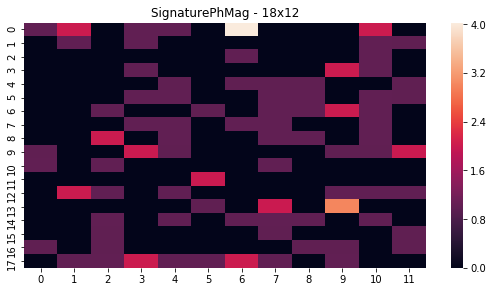

In [29]:
rs.plot("SignaturePhMag");

But not only that, but we also provide full integration with [Matplotlib](https://matplotlib.org/):

- We can, for example, provide the axis to plot (`ax`).
- Or change the color palette (`cmap`).

In this case, any extra parameters that we give to the plot method for the `SignaturePhMag` feature will be sent to the function.
[seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

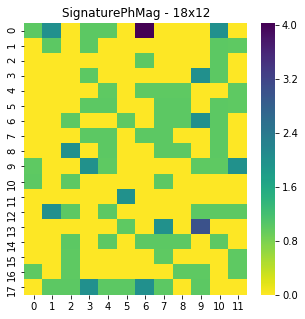

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
rs.plot("SignaturePhMag", ax=ax, cmap="viridis_r");

The catch is, by default all the extractors can't plot their features.

Let's try to plot the feature from the first example `magmax` or `mintime`

In [31]:
rs.plot("magmax")

PlotFeatureNotImplementedError: magmax

<Figure size 648x324.72 with 0 Axes>